# day 1-2 数据预处理 
（`SimpleImputer`, `StandardScaler`, `OneHotEncoder`）、`train_test_split`、`LogisticRegression` + `classification_report`；任务：UCI`Adult`（准确率 >70%）

## 下载数据集

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#避免重复下载，这个cell只运行一次
from ucimlrepo import fetch_ucirepo 
adult = fetch_ucirepo(id=2) 
X = adult.data.features 
X.to_csv('./data/day1-2/X.csv', index=False)
y = adult.data.targets 
y.to_csv('./data/day1-2/y.csv', index=False)

In [2]:
X = pd.read_csv('./data/day1-2/X.csv')
y = pd.read_csv('./data/day1-2/y.csv')
#数据清洗（血的教训）
y_series = y.iloc[:, 0] # 获取目标列的 Series
y_series = y_series.str.strip() # 去掉前后的空格
y = y_series.str.replace(r'\.$', '', regex=True) # 去掉字符串末尾的点（如果存在）
#确保y中只有两种类别
print(y.unique()) 

['<=50K' '>50K']


In [3]:
print(X.isnull().sum())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64


## 划分测试集  
一定是先划分测试集，在训练集上计算统计量，然后应用于全集的缺失值处理。  
否则测试集的信息会混入训练，造成**信息泄露**！！！

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) #返回的是ndarray，转换成df保存列名索引
x_train = pd.DataFrame(x_train,columns=X.columns)
x_test = pd.DataFrame(x_test,columns=X.columns)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39073 entries, 37193 to 15795
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             39073 non-null  int64 
 1   workclass       38301 non-null  object
 2   fnlwgt          39073 non-null  int64 
 3   education       39073 non-null  object
 4   education-num   39073 non-null  int64 
 5   marital-status  39073 non-null  object
 6   occupation      38299 non-null  object
 7   relationship    39073 non-null  object
 8   race            39073 non-null  object
 9   sex             39073 non-null  object
 10  capital-gain    39073 non-null  int64 
 11  capital-loss    39073 non-null  int64 
 12  hours-per-week  39073 non-null  int64 
 13  native-country  38861 non-null  object
dtypes: int64(6), object(8)
memory usage: 4.5+ MB


这里也有个坑！  
scikit-learn 的输入： 大多数 scikit-learn 的 Estimator (模型) 和 Transformer (预处理器，比如 StandardScaler, SimpleImputer) 在接收数据时，更喜欢   
或默认处理 NumPy 数组。你把 DataFrame 或 Series 传进去，它们在内部通常会先转成 NumPy 数组再操作。   
scikit-learn 的输出： 更重要的是，scikit-learn 的许多方法，比如：   
train_test_split()：   
StandardScaler().fit_transform() 和 .transform()   
SimpleImputer().fit_transform() 和 .transform()   
模型的 predict() 和 predict_proba()   
它们在处理完后，默认返回的也是 NumPy 数组！

***numpy数组是没有列名和索引的！！***  
如果后续要用到列名和索引，用type()检查一下，不是dataframe的话转回来。

## 缺失值处理
- 对于数值特征和类别特征要使用不同的方式：均值、众数、中位数、或者通过 fill_value 参数自定义填充值。  
- SimpleImputer默认把np.nan视为缺失值，可以通过missing_values参数自己定义缺失值，包括int, float, str, np.nan, None or pandas.NA。  
- 对于类别特征，一般先处理缺失值再独热编码。如果认为缺失本身蕴含了一定信息就使用自定义的的fill_value='missing'，但是会引入稀疏性。如果相信缺失值最有可能属于众数类别，而且占比小，完全随机，则使用众数strategy，但是可能会引入偏差，扭曲原特征分布。 
- SimpleImputer输出的是ndarray。



In [5]:
categorical_features = ['workclass','education','marital-status'
,'occupation','relationship','race','sex','native-country']
x_train.loc[:, categorical_features] = x_train.loc[:, categorical_features].replace('?', np.nan)
x_test.loc[:, categorical_features] = x_test.loc[:, categorical_features].replace('?', np.nan)

In [7]:
print(x_train.isnull().sum())

age                  0
workclass         2222
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2231
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     677
dtype: int64


小心！数据集中的缺失值可能不止一种！  
把数据集中的'?'（或者其他类型的缺失值）都转化成np.nan  
再使用SimpleImputer处理缺失值

In [9]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='most_frequent')
imp.fit(x_train)
x_train.info()
x_train = imp.transform(x_train)
x_test = imp.transform(x_test)
x_train = pd.DataFrame(x_train, columns=X.columns)
x_test = pd.DataFrame(x_test, columns=X.columns)
print(x_train.isnull().sum())
x_train.info()
#这里info是为了找到哪里把X_train的所有列都被转化成object类型，导致后面画图的时候报错
#就是这里，imp作用于整个dataframe，因为有不同数据类型的列，于是都被识别为object。后面有解决方法：ColumnTransformer


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39073 entries, 0 to 39072
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             39073 non-null  object
 1   workclass       39073 non-null  object
 2   fnlwgt          39073 non-null  object
 3   education       39073 non-null  object
 4   education-num   39073 non-null  object
 5   marital-status  39073 non-null  object
 6   occupation      39073 non-null  object
 7   relationship    39073 non-null  object
 8   race            39073 non-null  object
 9   sex             39073 non-null  object
 10  capital-gain    39073 non-null  object
 11  capital-loss    39073 non-null  object
 12  hours-per-week  39073 non-null  object
 13  native-country  39073 non-null  object
dtypes: object(14)
memory usage: 4.2+ MB
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relati

In [10]:
numerical_features = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
for col in numerical_features:
     x_train[col] = x_train[col].astype('int64')
     x_test[col] = x_test[col].astype('int64')
print(x_train[numerical_features].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39073 entries, 0 to 39072
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             39073 non-null  int64
 1   fnlwgt          39073 non-null  int64
 2   education-num   39073 non-null  int64
 3   capital-gain    39073 non-null  int64
 4   capital-loss    39073 non-null  int64
 5   hours-per-week  39073 non-null  int64
dtypes: int64(6)
memory usage: 1.8 MB
None


## OneHotEncoder:对每一个分类特征独热编码
- sparse 参数控制是否输出稀疏矩阵，默认true  
- handle_unknown 决定当transform时遇到fit时没有出现的特征怎么办，默认行为是报错，也可设置为'ignore'把新特征设为0
- drop 参数解决多重共线性，丢弃某些列
- categories 参数：指定每个独特的类别，配合handle_unknown识别训练集未出现的特征类别

In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
x_cat = x_train[categorical_features]

In [13]:
X_cat_hot = encoder.fit_transform(x_cat)
print(encoder.get_feature_names_out(categorical_features))

['workclass_Federal-gov' 'workclass_Local-gov' 'workclass_Never-worked'
 'workclass_Private' 'workclass_Self-emp-inc' 'workclass_Self-emp-not-inc'
 'workclass_State-gov' 'workclass_Without-pay' 'education_10th'
 'education_11th' 'education_12th' 'education_1st-4th' 'education_5th-6th'
 'education_7th-8th' 'education_9th' 'education_Assoc-acdm'
 'education_Assoc-voc' 'education_Bachelors' 'education_Doctorate'
 'education_HS-grad' 'education_Masters' 'education_Preschool'
 'education_Prof-school' 'education_Some-college'
 'marital-status_Divorced' 'marital-status_Married-AF-spouse'
 'marital-status_Married-civ-spouse'
 'marital-status_Married-spouse-absent' 'marital-status_Never-married'
 'marital-status_Separated' 'marital-status_Widowed'
 'occupation_Adm-clerical' 'occupation_Armed-Forces'
 'occupation_Craft-repair' 'occupation_Exec-managerial'
 'occupation_Farming-fishing' 'occupation_Handlers-cleaners'
 'occupation_Machine-op-inspct' 'occupation_Other-service'
 'occupation_Priv-hous

## StandardScaler
看看数据分布，对数值特征进行标准化。  
有的模型对数据的尺度非常敏感，如：  
基于距离的模型： k-近邻 (k-NN)、支持向量机 (SVM)、k-均值聚类 (k-Means) 等。这些模型计算样本之间的距离。如果某个特征的取值范围很大（比如年龄是 0-100，但薪水是 10k-100k），那薪水这个特征的微小变化，在距离计算中就会被放大得不成比例，压倒年龄的影响。标准化后，所有特征都在相似的尺度上，距离计算更公平。  
基于梯度的模型： 线性回归 (Linear Regression)、岭回归 (Ridge)、Lasso、逻辑回归 (Logistic Regression)、神经网络 (Neural Networks) 等，特别是使用梯度下降优化算法的时候。特征尺度不一致会导致代价函数（Loss Function）的等高线呈椭圆形，梯度下降路径会变得曲折，收敛速度变慢，甚至难以找到最优解。标准化后，等高线更接近圆形，梯度下降能更快更稳定地收敛！🏃‍♂️💨   
正则化模型： Ridge (L2) 和 Lasso (L1) 正则化是对模型系数进行惩罚。如果特征尺度差异很大，模型为了给一个取值范围小的特征一个足够的影响力，可能会被迫赋予它一个很大的系数，而这个大系数就会受到正则化的严厉惩罚。标准化后，特征尺度一致，正则化会更公平地对待所有特征的系数。

**pd.plotting.scatter_matrix()** 对角线上是每个特征的hist或者kde，其他地方是不同特征之间的散点图。

In [14]:
numerical_features = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
x_num = x_train[numerical_features]
x_num.info()
#这里一定要确定dtypes是int64。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39073 entries, 0 to 39072
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             39073 non-null  int64
 1   fnlwgt          39073 non-null  int64
 2   education-num   39073 non-null  int64
 3   capital-gain    39073 non-null  int64
 4   capital-loss    39073 non-null  int64
 5   hours-per-week  39073 non-null  int64
dtypes: int64(6)
memory usage: 1.8 MB


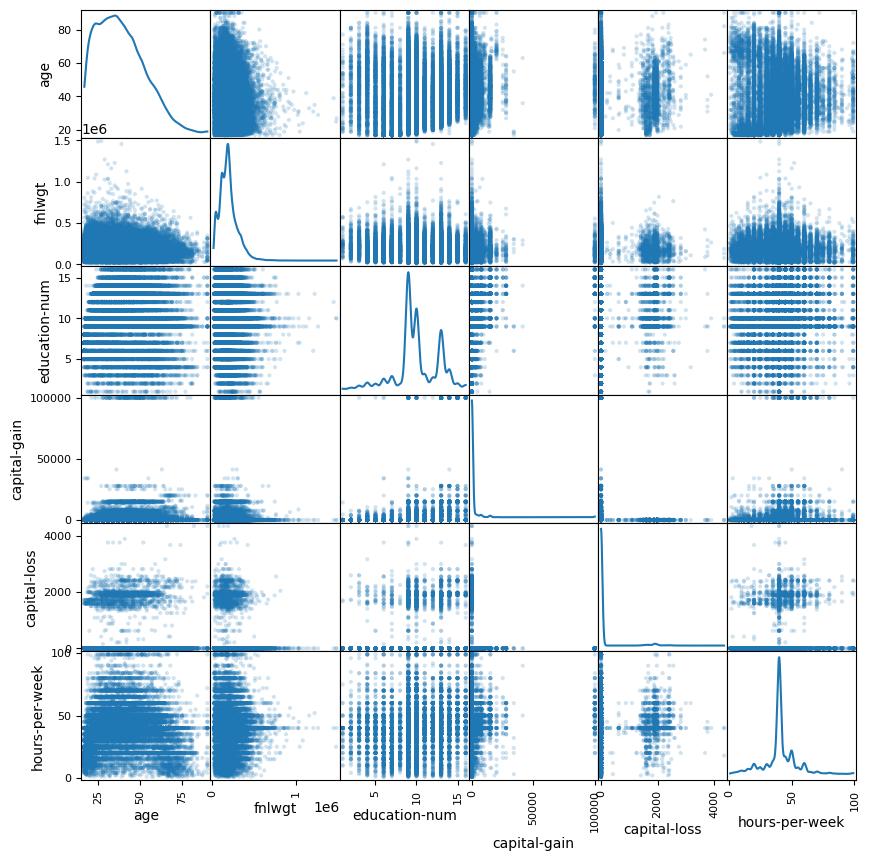

In [15]:
pd.plotting.scatter_matrix(x_num, alpha=0.2, figsize=(10, 10), diagonal='kde');

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_num)
x_scaled = pd.DataFrame(x_scaled, columns=x_num.columns) #下一个函数不能输入ndarray

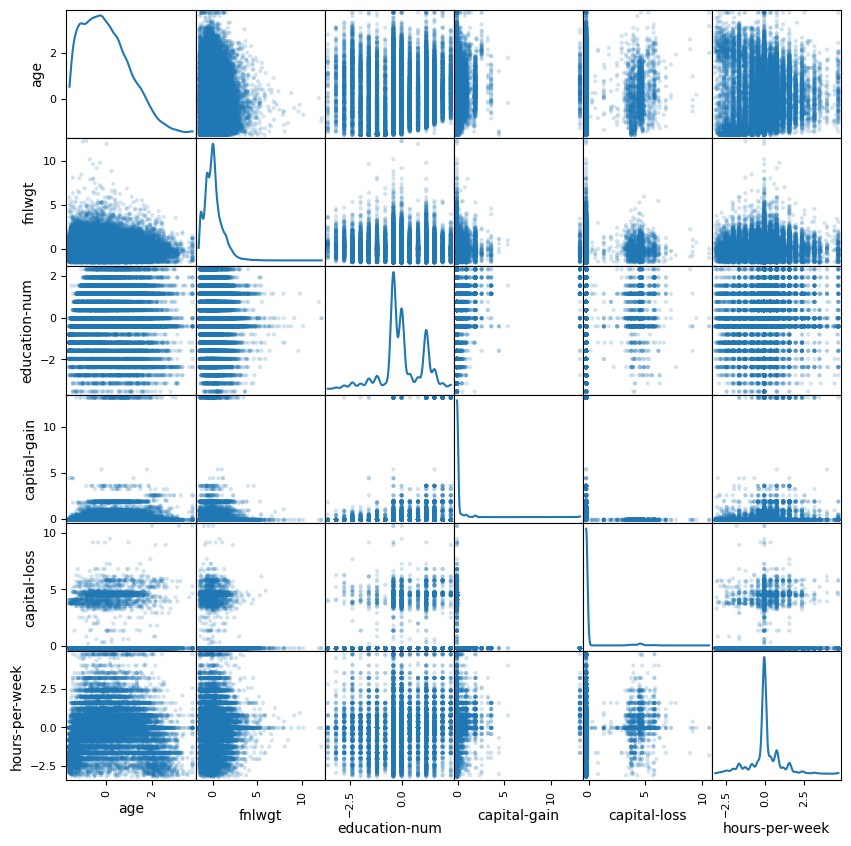

In [17]:
pd.plotting.scatter_matrix(x_scaled, alpha=0.2, figsize=(10, 10), diagonal='kde');

分布形状没变，但是确实标准化了。

In [18]:
x_scaled.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,3.907300e+04,3.907300e+04,3.907300e+04,3.907300e+04,3.907300e+04,3.907300e+04
mean,1.862145e-16,-4.455326e-17,-7.637702e-17,1.645743e-17,-8.801543e-17,6.382937e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.574700e+00,-1.679504e+00,-3.538730e+00,-1.455235e-01,-2.166684e-01,-3.179147e+00
25%,-7.739802e-01,-6.834746e-01,-4.201077e-01,-1.455235e-01,-2.166684e-01,-3.233856e-02
50%,-1.188459e-01,-1.108981e-01,-3.027992e-02,-1.455235e-01,-2.166684e-01,-3.233856e-02
75%,6.818739e-01,4.558666e-01,7.493756e-01,-1.455235e-01,-2.166684e-01,3.710984e-01
max,3.739167e+00,1.228894e+01,2.308687e+00,1.318778e+01,1.059731e+01,4.728217e+00


## 最佳实践
使用**ColumnTransformer**结合**pipeline**

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# 定义不同的处理步骤
# 创建数值imputer，对数值列用 mean 填充
numerical_features = ['age', 'fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
# 对于分类特征，我们先填充，再编码。这需要一个小的pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' 防止测试集出现新类别报错
])

# 创建 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # 'passthrough' 保留未指定的列 (这里没有，但常用)
    # remainder='drop' 会丢弃未指定的列
)

# 使用 preprocessor 对数据进行 fit_transform
# 注意：preprocessor 的输入是整个 DataFrame！
X_train_processed = preprocessor.fit_transform(x_train)

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
model = LogisticRegression(max_iter=200)
y_train = y_train.values.ravel()
model.fit(X_train_processed,y_train)

LogisticRegression(max_iter=200)

In [22]:
x_test = preprocessor.transform(x_test)
# 预测
y_pred = model.predict(x_test)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      7414
        >50K       0.74      0.57      0.65      2355

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.84      0.85      0.84      9769



 模型在识别占大多数的 <=50K 类别时表现非常出色（高 Precision 和 Recall）。但在识别占少数的 >50K 类别时，虽然 Precision 还行（预测是 >50K 的有 74% 是对的），但 Recall 较低（只找到了 58% 的真 >50K 样本）。这意味着模型更容易把高收入样本误判成低收入样本。Recall的macro avg远小于weighted进一步说明这一点。

这里就需要考虑**Precision和Recall的权衡**。   
针对类别不平衡和提高少数类性能，可以考虑的技术有：  
欠采样 (Undersampling) 多数类： 随机删除一部分多数类样本。  
过采样 (Oversampling) 少数类： 复制少数类样本，或者使用 SMOTE 等技术生成合成的少数类样本。  
调整模型参数： 在逻辑回归中，可以调整类别权重 (class_weight='balanced')，让模型在训练时更关注少数类。或者调整模型的分类阈值（默认是 0.5 概率，可以调低阈值来提高少数类的 Recall）。  
尝试其他模型： 树模型（如随机森林、梯度提升）对类别不平衡的鲁棒性通常比线性模型要好一些。
